In [73]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup, Comment
from fake_useragent import UserAgent
import time
import os
import requests, re
import random
import string
import pickle

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

## Scraping basketball-reference for box-scores for each NBA game

### Using Selenium to webscrape

In [2]:
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [ ]:
driver = webdriver.Chrome(chromedriver)
driver.get("https://www.basketball-reference.com/boxscores/?month=10&day=26&year=2010")

#### Defining and calling a function to grab all the urls of box-scores from every NBA game

In [ ]:
box_score_urls = []

def getting_box_scores():
    links = driver.find_elements_by_xpath('//*[@id="content"]/div[3]//a[@href]')
    for link in links:
        if 'boxscores' in link.get_attribute('href') and 'Final' in link.text:
            box_score_urls.append(link.get_attribute('href'))
            print (len(box_score_urls))

In [ ]:
while int(driver.find_element_by_xpath('//*[@id="content"]/h1').text[-4:]) <= 2010:
    getting_box_scores()
    next_day = driver.find_element_by_xpath('//*[@id="content"]/div[1]/a[2]').get_attribute('href')
    driver.get(next_day)
    time.sleep(5)

#### Storing each list of box_score_urls in a pickle file to use later

In [ ]:
with open('box_score_urls_practice', 'wb') as handle:
    pickle.dump(box_score_urls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('box_score_urls_practice', 'rb') as boxes:
    box_score_urls = pickle.load(boxes)

In [ ]:
len(box_score_urls)

In [4]:
driver = webdriver.Chrome(chromedriver)

#### Grabbing all necessary information from each box_score_url using selenium again

In [5]:
box_scores = {}

for box_score_url in box_score_urls:
    driver.get(box_score_url)
    time.sleep(10)
    
    date = box_score_url.split('/')[-1][0:8]
    year = date[0:4]
    month = date[4:6]
    day = date[6:8]
    
    away_team = driver.find_element_by_xpath('//*[@id="line_score"]/tbody/tr[2]/td[1]/a').text
    home_team = driver.find_element_by_xpath('//*[@id="line_score"]/tbody/tr[3]/td[1]/a').text
    
    box_scores[away_team+'@'+home_team] = [month, day, year, away_team, home_team]
    
    away_basic_stats = driver.find_elements_by_xpath('//*[@id="box_'+away_team.lower()+'_basic"]/tfoot/tr//td')
    for basic_stat in away_basic_stats[:-1]:
        box_scores[away_team+'@'+home_team].append(float(basic_stat.text))
    away_adv_stats = driver.find_elements_by_xpath('//*[@id="box_'+away_team.lower()+'_advanced"]/tfoot/tr//td')
    for adv_stat in away_adv_stats[1:]:
        box_scores[away_team+'@'+home_team].append(float(adv_stat.text))
    
    home_basic_stats = driver.find_elements_by_xpath('//*[@id="box_'+home_team.lower()+'_basic"]/tfoot/tr//td')
    for basic_stat in home_basic_stats[:-1]:
        box_scores[away_team+'@'+home_team].append(float(basic_stat.text))
    home_adv_stats = driver.find_elements_by_xpath('//*[@id="box_'+home_team.lower()+'_advanced"]/tfoot/tr//td')
    for adv_stat in home_adv_stats[1:]:
        box_scores[away_team+'@'+home_team].append(float(adv_stat.text))
        
    print (away_team+'@'+home_team)
    print (len(box_scores))

MIA@BOS
1
HOU@LAL
2
PHO@POR
3
BOS@CLE
4
CHA@DAL
5
UTA@DEN
6
HOU@GSW
7
POR@LAC
8
ATL@MEM
9
SAC@MIN
10
DET@NJN
11
MIL@NOH
12
CHI@OKC
13
MIA@PHI
14
IND@SAS
15
NYK@TOR
16
WAS@ORL
17
PHO@UTA
18
NYK@BOS
19
IND@CHA
20
MEM@DAL
21
OKC@DET
22
LAC@GSW
23
ORL@MIA
24
MIL@MIN
25
SAC@NJN
26
DEN@NOH
27
ATL@PHI
28
LAL@PHO
29
CLE@TOR
30
WAS@ATL
31
DET@CHI
32
SAC@CLE
33
DEN@HOU
34
PHI@IND
35
MIN@MEM
36
CHA@MIL
37
POR@NYK
38
NOH@SAS
39
DAL@LAC
40
GSW@LAL
41
MIA@NJN
42
UTA@OKC
43
POR@CHI
44
SAS@LAC
45
TOR@SAC
46
ATL@CLE
47
BOS@DET
48
MEM@LAL
49
MIN@MIA
50
POR@MIL
51
PHI@WAS
52
DET@ATL
53
MIL@BOS
54
DAL@DEN
55
MEM@GSW
56
NOH@HOU
57
OKC@LAC
58
CHA@NJN
59
MIN@ORL
60
IND@PHI
61
SAS@PHO
62
LAL@SAC
63
TOR@UTA
64
NYK@CHI
65
OKC@POR
66
CHI@BOS
67
LAC@DEN
68
CHA@DET
69
UTA@GSW
70
MIL@IND
71
TOR@LAL
72
ATL@MIN
73
MIA@NOH
74
WAS@NYK
75
NJN@ORL
76
CLE@PHI
77
MEM@PHO
78
ORL@CHA
79
DEN@DAL
80
NJN@MIA
81
NOH@MIL
82
TOR@POR
83
MEM@SAC
84
HOU@SAS
85
LAC@UTA
86
CLE@WAS
87
PHO@ATL
88
GSW@DET
89
MIN@HOU
90
POR@LAL
91
PHI@NYK


#### Dumping each dictionary of game_summaries into a pickle file to analyze later

In [6]:
with open('box_scores_practice', 'wb') as handle:
    pickle.dump(box_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('box_scores_practice', 'rb') as games:
    game_summaries = pickle.load(games)

In [3]:
game_summaries_df = pd.DataFrame.from_dict(data=game_summaries)
game_summaries_df = game_summaries_df.T
game_summaries_df.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
ATL@BOS,12,16,2010,ATL,BOS,240,34,68,0.5,3,...,25,70.6,47.1,63.6,13.8,1.7,12,100,117.3,103.5
ATL@CLE,11,02,2010,ATL,CLE,240,37,84,0.44,5,...,25.6,70.8,50.6,46.9,2.3,6,14.1,100,100.5,114.1
ATL@DET,12,14,2010,ATL,DET,240,30,68,0.441,6,...,26.3,91.7,58.1,70.3,10.4,11.1,12.1,100,118.8,92.2
ATL@IND,11,16,2010,ATL,IND,240,37,74,0.5,8,...,32.4,85.7,58.3,58.1,5.9,10.2,15.3,100,108.2,120
ATL@MEM,10,27,2010,ATL,MEM,240,42,80,0.525,8,...,20.5,76.9,47,32.5,7.1,6.3,12.6,100,105.1,120.2


### Getting Column names from basketball-reference

In [8]:
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

driver = webdriver.Chrome(chromedriver)
driver.get("https://www.basketball-reference.com/boxscores/201010260BOS.html")

In [9]:
basic_columns = driver.find_elements_by_xpath('//*[@id="box_mia_basic"]/thead/tr[2]//th')
adv_columns = driver.find_elements_by_xpath('//*[@id="box_mia_advanced"]/thead/tr[2]//th')

In [36]:
columns = ['Month', 'Day', 'Year', 'Away_Team', 'Home_Team']
teams = ['Away_', 'Home_']

for i in range(0,len(teams)):
    for basic in basic_columns[1:-1]:
        columns.append(teams[i]+basic.text)
    
    for adv in adv_columns[2:]:
        columns.append(teams[i]+adv.text)

In [37]:
game_summaries_df.columns = columns
game_summaries_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455 entries, ATL@BOS to WAS@TOR
Data columns (total 71 columns):
Month        455 non-null object
Day          455 non-null object
Year         455 non-null object
Away_Team    455 non-null object
Home_Team    455 non-null object
Away_MP      455 non-null object
Away_FG      455 non-null object
Away_FGA     455 non-null object
Away_FG%     455 non-null object
Away_3P      455 non-null object
Away_3PA     455 non-null object
Away_3P%     455 non-null object
Away_FT      455 non-null object
Away_FTA     455 non-null object
Away_FT%     455 non-null object
Away_ORB     455 non-null object
Away_DRB     455 non-null object
Away_TRB     455 non-null object
Away_AST     455 non-null object
Away_STL     455 non-null object
Away_BLK     455 non-null object
Away_TOV     455 non-null object
Away_PF      455 non-null object
Away_PTS     455 non-null object
Away_TS%     455 non-null object
Away_eFG%    455 non-null object
Away_3PAr    455 non-null object

In [38]:
game_summaries_df.head()

,Month,Day,Year,Away_Team,Home_Team,Away_MP,Away_FG,Away_FGA,Away_FG%,Away_3P,...,Home_ORB%,Home_DRB%,Home_TRB%,Home_AST%,Home_STL%,Home_BLK%,Home_TOV%,Home_USG%,Home_ORtg,Home_DRtg
ATL@BOS,12,16,2010,ATL,BOS,240,34,68,0.5,3,...,25,70.6,47.1,63.6,13.8,1.7,12,100,117.3,103.5
ATL@CLE,11,02,2010,ATL,CLE,240,37,84,0.44,5,...,25.6,70.8,50.6,46.9,2.3,6,14.1,100,100.5,114.1
ATL@DET,12,14,2010,ATL,DET,240,30,68,0.441,6,...,26.3,91.7,58.1,70.3,10.4,11.1,12.1,100,118.8,92.2
ATL@IND,11,16,2010,ATL,IND,240,37,74,0.5,8,...,32.4,85.7,58.3,58.1,5.9,10.2,15.3,100,108.2,120
ATL@MEM,10,27,2010,ATL,MEM,240,42,80,0.525,8,...,20.5,76.9,47,32.5,7.1,6.3,12.6,100,105.1,120.2


In [62]:
game_summaries_df['Home_Team_Win'] = 0

In [66]:
for i in range(0,len(game_summaries_df)):
    if game_summaries_df.iloc[i, 23] < game_summaries_df.iloc[i, 56]:
        game_summaries_df.iloc[i, -1] = 1

    if game_summaries_df.iloc[i, 23] > game_summaries_df.iloc[i, 56]:
        game_summaries_df.iloc[i, -1] = 0

In [67]:
game_summaries_df.head()

,Month,Day,Year,Away_Team,Home_Team,Away_MP,Away_FG,Away_FGA,Away_FG%,Away_3P,...,Home_DRB%,Home_TRB%,Home_AST%,Home_STL%,Home_BLK%,Home_TOV%,Home_USG%,Home_ORtg,Home_DRtg,Home_Team_Win
ATL@BOS,12,16,2010,ATL,BOS,240,34,68,0.5,3,...,70.6,47.1,63.6,13.8,1.7,12,100,117.3,103.5,1
ATL@CLE,11,02,2010,ATL,CLE,240,37,84,0.44,5,...,70.8,50.6,46.9,2.3,6,14.1,100,100.5,114.1,0
ATL@DET,12,14,2010,ATL,DET,240,30,68,0.441,6,...,91.7,58.1,70.3,10.4,11.1,12.1,100,118.8,92.2,1
ATL@IND,11,16,2010,ATL,IND,240,37,74,0.5,8,...,85.7,58.3,58.1,5.9,10.2,15.3,100,108.2,120,0
ATL@MEM,10,27,2010,ATL,MEM,240,42,80,0.525,8,...,76.9,47,32.5,7.1,6.3,12.6,100,105.1,120.2,0


In [68]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc, f1_score, precision_recall_curve, log_loss, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

In [75]:
features = ['Away_TS%', 'Away_eFG%', 'Away_ORB%', 'Away_DRB%', 'Away_TOV%', 'Away_FTr',
           'Home_TS%', 'Home_eFG%', 'Home_ORB%', 'Home_DRB%', 'Home_TOV%', 'Home_FTr']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(game_summaries_df[features], game_summaries_df.iloc[:,-1], test_size=0.3, random_state=42)

In [77]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

predictions = log_model.predict(X_test)

In [83]:
log_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
print ('Accuracy score: ' + str(accuracy_score(y_test, predictions)))
print ('Precision score: ' + str(precision_score(y_test, predictions)))
print ('Recall score: ' + str(recall_score(y_test, predictions)))

Accuracy score: 0.839416058394
Precision score: 0.79
Recall score: 0.9875


Area under the curve: 0.97850877193


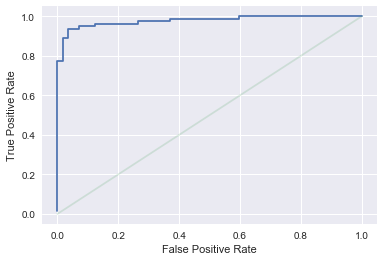

In [79]:
model_pred_vec = log_model.predict_proba(X_test)[:,1]
model_fpr, model_tpr, model_thres = roc_curve(y_test, model_pred_vec)
print ('Area under the curve: ' + str(auc(model_fpr, model_tpr)))
    
plt.plot(model_fpr, model_tpr)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), alpha=0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

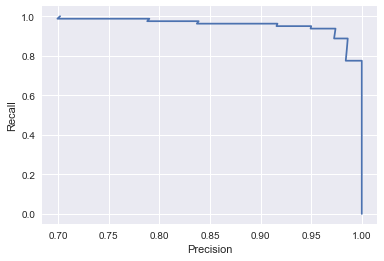

In [80]:
model_precision, model_recall, model_threshold = precision_recall_curve(y_test, model_pred_vec)
plt.plot(model_precision, model_recall)
plt.xlabel('Precision')
plt.ylabel('Recall')

In [81]:
model_pred_vec

array([ 0.65031622,  0.57350458,  0.51403071,  0.74284012,  0.85787215,
        0.71854783,  0.72228422,  0.70198961,  0.59452141,  0.50637933,
        0.52547403,  0.61769253,  0.68328364,  0.80503247,  0.57721858,
        0.3941656 ,  0.80065931,  0.70453386,  0.72716423,  0.57066108,
        0.62741029,  0.68221937,  0.37322225,  0.88899815,  0.55151978,
        0.45046546,  0.4941951 ,  0.63863108,  0.72934151,  0.61857531,
        0.46083012,  0.87692851,  0.56610092,  0.49918194,  0.76220699,
        0.53938411,  0.32860942,  0.56261398,  0.41318439,  0.58479557,
        0.72846775,  0.41583891,  0.67050775,  0.55669825,  0.48346919,
        0.37610796,  0.7718496 ,  0.63633938,  0.39177996,  0.66731792,
        0.7568667 ,  0.5947116 ,  0.7387998 ,  0.49909309,  0.77275239,
        0.67931933,  0.6212775 ,  0.57729895,  0.34145202,  0.80127425,
        0.6093328 ,  0.63090229,  0.61597599,  0.52680911,  0.88585661,
        0.52695009,  0.65533717,  0.74894446,  0.76344225,  0.30

In [84]:
def stat_modeling(m, x_train, x_test, y_train, y_test):
    model = m
    model.fit(x_train, y_train)
    
    model_pred = model.predict(x_test)
    
    print ('Accuracy score: ' + str(accuracy_score(y_test, model_pred)))
    print ('Precision score: ' + str(precision_score(y_test, model_pred)))
    print ('Recall score: ' + str(recall_score(y_test, model_pred)))
#    print ('F1 score: ' + str(f1_score(y_test, model_pred)))
    
    model_pred_vec = model.predict_proba(x_test)[:,1]
    model_fpr, model_tpr, model_thres = roc_curve(y_test, model_pred_vec)
    print ('Area under the curve: ' + str(auc(model_fpr, model_tpr)))
    
    plt.plot(model_fpr, model_tpr)
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), alpha=0.2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

def pr_curve(m, x_train, x_test, y_train, y_test):
    
    model = m
    model.fit(x_train, y_train)
    
    model_pred_vec = model.predict_proba(x_test)[:,1]
    
    model_precision, model_recall, model_threshold = precision_recall_curve(y_test, model_pred_vec)
    plt.plot(model_precision, model_recall)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    
    return model_precision, model_recall, model_threshold, model_pred_vec

Accuracy score: 0.85401459854
Precision score: 0.884615384615
Recall score: 0.8625
Area under the curve: 0.934429824561


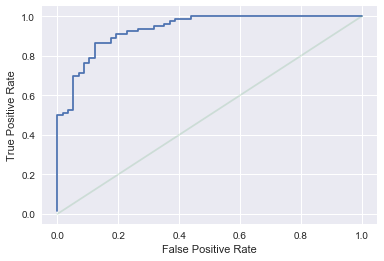

In [85]:
stat_modeling(GaussianNB(), X_train, X_test, y_train, y_test)

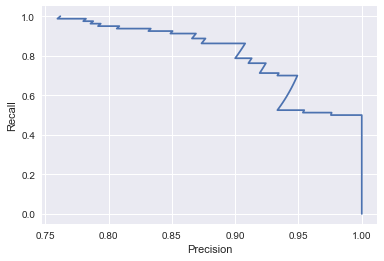

In [86]:
g_pre, g_re, g_thres, g_pred = pr_curve(GaussianNB(), X_train, X_test, y_train, y_test)

Accuracy score: 0.583941605839
Precision score: 0.595041322314
Recall score: 0.9
Area under the curve: 0.568640350877


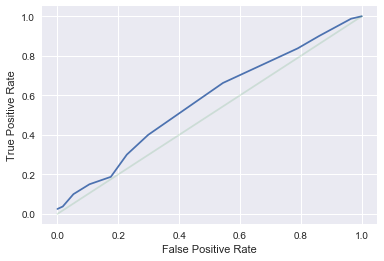

In [90]:
stat_modeling(KNeighborsClassifier(n_neighbors=30), X_train, X_test, y_train, y_test)

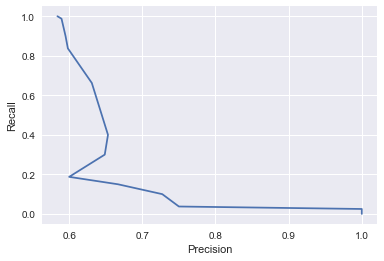

In [91]:
k_pre, k_re, k_thres, k_pred = pr_curve(KNeighborsClassifier(n_neighbors=30), X_train, X_test, y_train, y_test)

Accuracy score: 0.583941605839
Precision score: 0.598290598291
Recall score: 0.875
Area under the curve: 0.499561403509


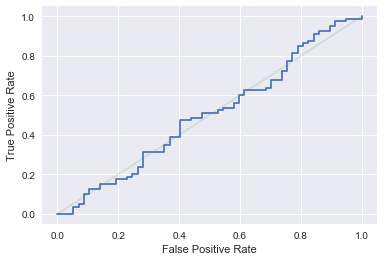

In [92]:
stat_modeling(SVC(probability=True), X_train, X_test, y_train, y_test)

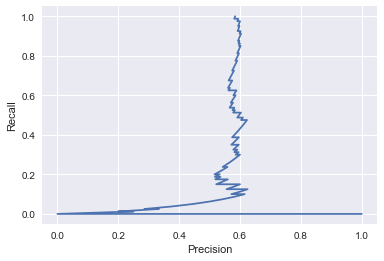

In [93]:
s_pre, s_re, s_thres, s_pred = pr_curve(SVC(probability=True), X_train, X_test, y_train, y_test)

Accuracy score: 0.861313868613
Precision score: 0.896103896104
Recall score: 0.8625
Area under the curve: 0.919188596491


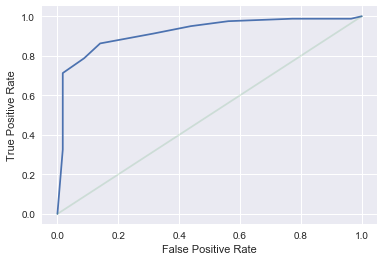

In [94]:
stat_modeling(RandomForestClassifier(max_depth=15), X_train, X_test, y_train, y_test)

Accuracy score: 0.795620437956
Precision score: 0.817073170732
Recall score: 0.8375
Area under the curve: 0.904714912281


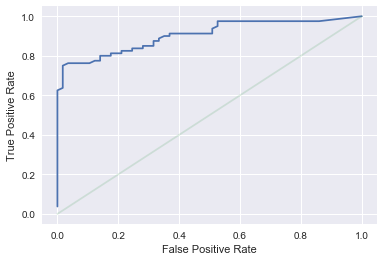

In [96]:
stat_modeling(GradientBoostingClassifier(loss='exponential', max_depth=30), X_train, X_test, y_train, y_test)

In [97]:
confusion_matrix(y_test, predictions)

array([[36, 21],
       [ 1, 79]])